## testing for pygenefinder

to do:

* nearest taxon for species with 16S blast results
* add custom sequences for blast search
* clustermap of features presence/absence


In [1]:
import sys,os,subprocess,glob,tempfile,time
import re
from importlib import reload
import pandas as pd
pd.set_option('display.max_columns', 14)
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.width', 180)
import numpy as np
import pylab as plt
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Alphabet import generic_dna
import urllib.request
sys.path.append('../')
from pygenefinder import tools, app
datadir = '../pygenefinder/data/'
dbdir = app.dbdir
tempdir = tempfile.gettempdir()
home = os.path.expanduser("~")
config_path = os.path.join(home,'.config/pygenefinder')
prokkadbdir = app.prokkadbdir
hmmdir = os.path.join(config_path, 'hmms')

links = app.links

In [ ]:
reload(app)
app.fetch_binaries()

In [63]:
un = pd.read_csv('../uniprot-reviewed_yes.tab',sep='\t')

In [15]:
un['gene'] = un['Gene names'].apply(lambda x: str(x).split(' ')[0], 1)

In [ ]:
';'.join(un['Keywords'][:20]).split(';')

## aragorn

In [110]:
def aragorn(infile):
    cmd = 'aragorn -l -gcbact -t -w %s -o /tmp/aragorn.txt' %infile
    tmp = subprocess.check_output(cmd, shell=True)
    df = tools.read_aragorn('/tmp/aragorn.txt')
    return df

df = aragorn('../ana_files/RF15A.fa')
df

,contig,product,feat_type,start,end,anticodon,strand
0,NODE_1_length_272178_cov_58.4899,tRNA-Leu,tRNA,16210,16295,TAG,-1
1,NODE_1_length_272178_cov_58.4899,tRNA-Trp,tRNA,16333,16407,CCA,-1
2,NODE_1_length_272178_cov_58.4899,tRNA-Leu,tRNA,16441,16526,TAG,-1
3,NODE_1_length_272178_cov_58.4899,tRNA-Leu,tRNA,16906,16992,CAG,-1
4,NODE_1_length_272178_cov_58.4899,tRNA-Leu,tRNA,17301,17386,TAG,-1
...,...,...,...,...,...,...,...
70,NODE_172_length_452_cov_317.597,tRNA-Ala,tRNA,168,244,TGC,1
71,NODE_190_length_408_cov_124.623,tRNA-Ile,tRNA,43,120,GAT,1
72,NODE_190_length_408_cov_124.623,tRNA-Ala,tRNA,168,244,TGC,1
73,NODE_192_length_252_cov_2.264,tRNA-Asp,tRNA,3,80,GTC,1


## hmmer

In [ ]:
def hmmer(infile, threads=4, hmm_file=None):
    """Run hmmer"""
    
    def get_contig(x):
        return ('_').join(x.split('_')[:-1])
    if getattr(sys, 'frozen', False):
        hmmpresscmd = tools.resource_path('bin/hmmpress.exe')
        hmmscancmd = tools.resource_path('bin/hmmscan.exe')
    else:
        hmmpresscmd = 'hmmpress'
        hmmscancmd = 'hmmscan'    
    df = tools.fasta_to_dataframe(infile)
    fetch_sequence_from_url('HAMAP.hmm', hmmdir, ext='')
    db = os.path.join(hmmdir,'HAMAP.hmm')
    cmd = '%s -f %s' %(hmmpresscmd,db)
    tmp = subprocess.check_output(cmd, shell=True)
    outfile = os.path.join(tempdir, 'hmm.txt')
    cmd = "{c} --noali --notextw --acc -E 1e-4 --cpu {t} --tblout {o} -o hmm.out {db} {i}".format(
                                c=hmmscancmd,t=threads,db=db,i=infile,o=outfile)
    print (cmd)
    tmp = subprocess.check_output(cmd, shell=True)
    h = tools.read_hmmer3(outfile)
    #print (df)
    df = h.merge(df,on='name',how='left')
    #print (df[:5])
    #get coords from prodigal fasta heading if available
    df[['start','end','strand']] = df.description.apply(get_prodigal_coords,1)
    df['contig'] = df['name'].apply(get_contig)
    return df

h=hmmer('../prodigal.faa', 10)
h.iloc[0]

In [5]:
def fetch_sequence_from_url(name='card', path=None, ext='.fa'):
    """get sequences"""
    
    if path == None:
        path = dbdir
    if not os.path.exists(path):
        os.makedirs(path)

    if name in links:
        url = links[name]
    else:
        print('no such name')
        return        

    filename = os.path.join(path,"%s%s" %(name,ext))
    print (filename)
    if not os.path.exists(filename):
        try:
            urllib.request.urlretrieve(url, filename)
        except:
            print ('no such URL?')
    return

fetch_sequence_from_url('resfinder')

/home/damien/.config/pygenefinder/db/resfinder.fa


In [3]:
def make_target_database(filenames):
    """Make blast dbs of multiple input files"""

    rec=[]
    for n in filenames:
        seqs = list(SeqIO.parse(n,'fasta'))
        for s in seqs:
            s.id = n + '~' + s.id
        rec.extend(seqs)

    targfile = os.path.join(tempdir, 'targets.fasta')
    SeqIO.write(rec, targfile, 'fasta')
    make_blast_database(targfile)
    return

def make_blast_database(filename, dbtype='nucl'):
    """Create a blast db from fasta file"""
    
    cmd = 'makeblastdb'
    #if frozen app
    if getattr(sys, 'frozen', False):
        print ('bundled app in windows')
        cmd = tools.resource_path('bin/makeblastdb.exe')

    cline = '%s -dbtype %s -in %s' %(cmd,dbtype,filename)
    subprocess.check_output(cline, shell=True)
    return

make_target_database(['../test_files/RF15B.fa','../test_files/RF15A.fa'])

## prokka type annotation

1. run prodigal 
2. blast output protein seqs 
3. select best hits
5. run aragorn
6. run hmmer
7. merge results to dataframe
8. make genbank from results

* https://www.biostars.org/p/79392/
* https://www.protocols.io/view/week-4-calling-open-reading-frames-with-prodigal-u-gz3bx8n

In [112]:
def prodigal(infile):
    """Run prodigal"""

    cmd = 'prodigal'
    if getattr(sys, 'frozen', False):
        cmd = tools.resource_path('bin/prodigal.exe')
    #name = os.path.splitext(infile)[0]
    name = os.path.join(tempdir,'prodigal')
    cmd = '{c} -i {i} -c -m -a {n}.faa -f gff -o {n}.gff -p single'.format(i=infile,c=cmd,n=name)
    subprocess.check_output(cmd, shell=True)
    resfile = os.path.join(tempdir, 'prodigal.faa')
    return resfile

def get_prodigal_coords(x):
    s = re.split('\#|\s',x.replace(' ',''))
    coords = [int(i) for i in s[1:4]]
    return  pd.Series(coords)

def prokka_header_info(x):
    s = re.split('~~~',x)
    return pd.Series(s)

In [51]:
def run_annotation(infile, prefix=None, ident=70, threads=4, kingdom='bacteria', **kwargs):
    """
    Annotate nucelotide sequences (usually a draft assembly with contigs)
    using prodigal and blast to prokka seqs. Writes a genbank file to the
    same folder.
    Args:
        prefix: prefix for locus_tags
        infile: input fasta file
        outfile: output genbank
        hmmer: run hmmer
    returns:
        a list of SeqRecords with the features
    """

    #get simple name for contig
    def get_contig(x):
        return ('_').join(x.split('_')[:-1])   
    if prefix == None:
        prefix = app.create_locus_tag(infile)
    sprot = 'sprot_%s' %kingdom 
    dbs = ['IS','amr',sprot]
    evalues = [1e-10,1e-100,1e-4]
    #run prodigal
    resfile = prodigal(infile)
    #read in prodigal fasta to dataframe
    df = tools.fasta_to_dataframe(resfile)
    df[['start','end','strand']] = df.description.apply(get_prodigal_coords,1)
    df['feat_type'] = 'CDS'
    df['contig'] = df['name'].apply(get_contig)
    
    #get target seqs
    seqs = list(SeqIO.parse(resfile,'fasta'))
    #read input file nucleotide seqs
    contigs = SeqIO.to_dict(SeqIO.parse(infile,'fasta'))
    #print (df[:5])
    res = []
    i=0
    for db in dbs:
        app.fetch_sequence_from_url(db, path=prokkadbdir)
        #make blast db of prokka proteins
        dbname = os.path.join(prokkadbdir,'%s.fa' %db)
        tools.make_blast_database(dbname, dbtype='prot')
        print ('blasting %s ORFs to %s' %(len(seqs),db))
        bl = tools.blast_sequences(dbname, seqs, maxseqs=1, evalue=evalues[i],
                                    cmd='blastp', show_cmd=True, threads=threads, **kwargs)
        bl = bl[bl.pident>ident]
        if len(bl)==0:
            i+=1
            continue
        bl[['protein_id','gene','product','cog']] = bl.stitle.apply(prokka_header_info,1)

        cols = ['qseqid','sseqid','pident','sstart','send','protein_id','gene','product']
        #print (len(bl))
        bl = bl.sort_values(['qseqid','pident'], ascending=False).drop_duplicates(['qseqid'])[cols]
        #print (len(bl))

        #merge blast result with prodigal sequences
        found = df.merge(bl,left_on='name',right_on='qseqid',how='right')
        #get remaining sequences with no hits to this db
        df = df[~df.name.isin(bl.qseqid)]
        #new sequences to blast in the next iteration
        seqs = tools.dataframe_to_seqrecords(df, idkey='name')
        #print (found)
        res.append(found)
        print ('%s sequences unassigned' %len(df))
        i+=1
    #all results together
    res = pd.concat(res)    
    #print (res) 
    
    #-------------------------------------------------------
    #run hmmer on unassigned  
    if kingdom == 'bacteria':
        print ('running hmmer')
        #write unknowns out
        SeqIO.write(seqs,'unknowns.fa','fasta')
        hmmdf = hmmer('unknowns.fa', threads=threads) 
        #print (hmmdf.dtypes)
        res = pd.concat([res,hmmdf], sort=False)    
    
    #get tRNAs with aragorn
    print ('running aragorn')
    arag = aragorn(infile)
    #print (arag)
    res = pd.concat([res,arag], sort=False)
    
    #remaining unknowns are hypothetical proteins
    unknown = df[~df.name.isin(res.name)].copy()
    unknown['product'] = 'hypothetical protein'
    res = pd.concat([res,unknown], sort=False)
    
    #post process dataframe
    #res = res.fillna('')
    res['translation'] = res.sequence
    #res['gene'] = res.gene.fillna('')
    res = res.reset_index(drop=True)
    
    #print (res['product'].value_counts())  
    #print (res.dtypes)
    
    #-------------------------------------------------------
    #we then write all found sequences to seqrecord/features
    l=1  #counter for assigning locus tags
    recs = []
    #group by contig and get features for each protein found
    for c,df in res.groupby('contig'):
        contig = get_contig(c)
        #truncated label for writing to genbank
        label = ('_').join(c.split('_')[:2])
        #print (c, len(df), label)
        nucseq = contigs[c].seq
        rec = SeqRecord(nucseq)
        rec.seq.alphabet = generic_dna
        rec.id = label
        rec.name = label
        rec.COMMENT = 'annotated with pygenefinder'
        df = df.sort_values('start')
        qcols = ['gene','product','locus_tag','translation']
        for i,row in df.iterrows():
            row['locus_tag'] = '{p}_{l:05d}'.format(p=prefix,l=l)
            row = row.dropna()     
            cols = [c for c in qcols if c in row.index]                 
            quals = row[cols].to_dict()
            #print (quals)
            feat = SeqFeature(FeatureLocation(row.start,row.end,row.strand), strand=row.strand,
                              type=row.feat_type, qualifiers=quals)
            rec.features.append(feat)
            l+=1          
        recs.append(rec)
    return res,recs

In [52]:
reload(tools)
reload(app)

st=time.time()
#res,recs = run_annotation('../contigs.fa', threads=10)
#res,recs = run_annotation('../viruses/GCA_009858895.3_ASM985889v3_genomic.fna', kingdom='viruses', threads=10)
#res,recs = run_annotation('../test_files/GCA_000947895.1.fa', threads=12)
res,recs = run_annotation('../ana_files/RF2A.fa', threads=12)
print (time.time()-st)
tools.recs_to_genbank(recs, 'annot.gbk')

/home/damien/.config/pygenefinder/prokka/IS.fa
blasting 3985 ORFs to IS
blastp -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db /home/damien/.config/pygenefinder/prokka/IS.fa -evalue 1e-10 -max_target_seqs 1 -num_threads 12
3953 sequences unassigned
/home/damien/.config/pygenefinder/prokka/amr.fa
blasting 3953 ORFs to amr
blastp -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db /home/damien/.config/pygenefinder/prokka/amr.fa -evalue 1e-100 -max_target_seqs 1 -num_threads 12
3949 sequences unassigned
/home/damien/.config/pygenefinder/prokka/sprot_bacteria.fa
blasting 3949 ORFs to sprot_bacteria
blastp -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa 

In [50]:
print (res.columns)
print(res[['name', 'start', 'end','gene','contig','product']])

Index(['name', 'sequence', 'description', 'type', 'start', 'end', 'strand', 'feat_type', 'contig', 'qseqid', 'sseqid', 'pident', 'sstart', 'send', 'protein_id', 'gene', 'product',
       'query', 'score', 'evalue', 'EC', 'anticodon', 'translation'],
      dtype='object')
                   name  start    end gene          contig                           product
0     CDHH01000003.1_27  23865  24710       CDHH01000003.1    IS256 family transposase ISRo1
1     CDHH01000004.1_36  31732  32511       CDHH01000004.1   ISNCY family transposase ISRjo3
2     CDHH01000004.1_37  32501  33178       CDHH01000004.1  ISNCY family transposase ISMav10
3      CDHH01000028.1_4   5355   5738       CDHH01000028.1    IS21 family transposase ISMbo1
4     CDHH01000029.1_69  68780  70096       CDHH01000029.1   IS607 family transposase IS1539
...                 ...    ...    ...  ...             ...                               ...
4088  CDHH01000091.1_29  23603  24037  NaN  CDHH01000091.1              hypot

In [ ]:
print (res.contig.unique())
for i,df in res[:200].groupby('contig'):
    print (i)
    plot_segments(df,'start','end')
#print (pr)

In [21]:
def records_to_fasta(recs, outfile):
    """Write seqrecords features to a fasta file"""

    handle = open(outfile,'w+')
    for rec in recs:
        for feat in rec.features:        
            quals = feat.qualifiers
            SeqIO.write(SeqRecord(Seq(quals['translation']),id=quals['locus_tag']), handle, "fasta")
    return

records_to_fasta(pr, 'test.faa')

In [ ]:
reload(tools)
df=tools.genbank_to_dataframe('../amr_results/ecoli_HSP38.gbk')

In [119]:
reload(app)
reload(tools)
def find_genes(target, ref='card', ident=90, coverage=75, duplicates=False, threads=2, **kwds):
    """Find ref genes by blasting the target sequences.
    Args:
        target: target blast database
        ref: query sequences to search, e.g. contigs in an assembly
        
    """

    path = os.path.join(dbdir,'%s.fa' %ref)
    #the AMR db is the query for the blast
    queryseqs = list(SeqIO.parse(path,'fasta'))
    print ('blasting %s sequences' %len(queryseqs))
    bl = tools.blast_sequences(target, queryseqs, maxseqs=5, evalue=.01,
                               cmd='blastn', show_cmd=True, threads=int(threads))

    bl['qlength'] = bl.sequence.str.len()
    bl['coverage'] = bl.length/bl.qlength*100
    bl = bl[bl.coverage>coverage]
    bl = bl[bl.pident>ident]
    bl['filename'] = bl.sseqid.apply(lambda x: x.split('~')[0],1)
    bl['id'] = bl.filename.apply(lambda x: os.path.basename(x),1)
    bl['contig'] = bl.sseqid.apply(lambda x: x.split('~')[1],1)
    try:
        bl['gene'] = bl['qseqid'].apply(lambda x: x.split('~~~')[1],1)
    except:
        bl['gene'] = bl.qseqid

    #remove exact and close duplicates
    print (len(bl))
    bl = bl.sort_values(['contig','bitscore'], ascending=False).drop_duplicates(['contig','sstart','send'])
    print (len(bl))
    #if duplicates == False:
        #dist = 20
        #x=bl.sort_values(by=["contig","sstart"],ascending=False)
        #print (x[:15][x.columns[:5]])
        #unique = x.sstart.diff().abs().fillna(dist)        
        #bl = bl[unique>=dist]
    cols = ['gene','id','qseqid','pident','coverage','sstart','send','contig','description','filename','bitscore','qcovs','qseq','sseq']
    bl = bl[cols]
    return bl

filenames = glob.glob(os.path.join(app.datadir, '*.fa'))
print (filenames[:1])
app.make_target_database(filenames[:1])
targfile = os.path.join(app.tempdir, 'targets.fasta')
bl = find_genes(targfile, 'bacteria.16SrRNA', threads=10)
#bl = find_genes(targfile, 'card', threads=10)


['/home/farrell/gitprojects/pygenefinder/pygenefinder/data/ecoli_k12.fa']
blasting 20336 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db /tmp/targets.fasta -evalue 0.01 -max_target_seqs 5 -num_threads 10
6000
2999


In [ ]:
cols=['gene','sstart','send','description','bitscore','contig','coverage','pident','qcovs']
bl[cols][:20]

In [ ]:
reload(app)
reload(tools)
def find_genes2(query, ref='card', ident=90, coverage=75, duplicates=False, threads=2, **kwds):
    """Find ref genes by blasting the target sequences.
    Args:
        target: target blast database
        ref: query sequences to search, e.g. contigs in an assembly
        
    """

    targfile = app.make_target_database(os.path.join(dbdir,'%s.fa' %ref))    
    queryseqs = list(SeqIO.parse(query,'fasta'))
    print ('blasting %s sequences' %len(queryseqs))
    bl = tools.blast_sequences(targfile, queryseqs, maxseqs=5, evalue=.01,
                               cmd='blastn', show_cmd=True, threads=int(threads))

    bl['qlength'] = bl.sequence.str.len()
    bl['coverage'] = bl.length/bl.qlength*100
    #bl = bl[bl.coverage>coverage]
    bl = bl[bl.pident>ident]
    #bl = bl.sort_values(['contig','bitscore'], ascending=False).drop_duplicates(['contig','sstart','send'])
    return bl

ref = 'bacteria.16SrRNA'
print (os.path.join(dbdir,'%s.fa' %ref))

filenames = glob.glob(os.path.join(app.datadir, '*.fa'))
queryfile =  filenames[0]
queryfile = '../test_files/RF11.fa'
bl = find_genes2(queryfile, 'bacteria.16SrRNA', threads=10)
print (bl.columns)
print (bl[cols])

In [ ]:
feats = tools.genbank_to_dataframe('annot.gbk').sort_values('start').reset_index()
print (len(feats))
#print (feats)
#find interval overlaps to determine duplicate gene hits inside contig
left = [np.random.randint(0,10000) for i in range(300)]
right = [i+100 for i in left]

#df = pd.DataFrame({'left': [0,5,10,3,12,13,18,31], 'right':[4,8,13,7,19,16,23,35]})
df = pd.DataFrame({'left': left, 'right':right})
df = pd.DataFrame({'left': bl.sstart, 'right': bl.send})

#print (df)

def plot_segments(df, left='left',right='right'):
    
    v = df.sort_values([left, right])
    df = df.assign(Group=(v[right] - v[left].shift(-1)).shift().lt(12).cumsum())    
    f,ax=plt.subplots(1,1,figsize=(15,4))
    import matplotlib._color_data as mcd
    colors= list(mcd.XKCD_COLORS.values())
    y=0
    for i,g in df.groupby('Group'):
        h=0
        for j,r in g.iterrows():
            c = colors[y]
            ax.plot([r[left], r[right]], [h, h], '-', color=c, lw=3)
            h+=1
        y+=1

plot_segments(df)

In [ ]:
from intervaltree import Interval, IntervalTree
ivs = [(1, 2), (4, 7), (5, 9)]
t = IntervalTree(
 Interval(begin, end, "%d-%d" % (begin, end)) for begin, end in ivs
)
t

## estimate species
* use LCA method to get closest taxonomy from 16S blastn results 
* https://github.com/naturalis/Simple-LCA

In [ ]:
# get taxids for 16S accessions?
seqs = SeqIO.to_dict(SeqIO.parse(os.path.join(app.dbdir,'bacteria.16SrRNA.fa'),format='fasta'))
out=open('accessions.txt','w')
#for s in seqs:
#    out.write(seqs[s].id+'\n')

In [ ]:
def plot_tree(dend_file,name='',ax=None):
    """Plot phylo tree"""
    
    from Bio import Phylo
    if ax==None:
        f,ax=plt.subplots(1,1,figsize=(12,8))
    tree = Phylo.read(dend_file, "newick")
    ax.set_title(name)
    Phylo.draw(tree,axes=ax)
    ax.axis('off')
    return
                      
#blastn to 16S

#take top results (bitscore and coverage)
bl = bl.drop_duplicates('gene')
bl = bl[:10]
#print (bl[cols])
#print (bl.iloc[0])
qseq = bl.iloc[0].qseq
#add taxonomy info to blast results

#get query seq from best hit start/end and input fasta
name = 'rf11'
#get seqs from 16S hits
hits=[]
for id in bl.gene:    
    if id in seqs:
        r=seqs[id]
        r.name = r.description
        hits.append(r)
        print (r.id,r.description)
    
hits.append(SeqRecord(Seq(qseq), id=name))

SeqIO.write(hits,'hits.fa','fasta')
tools.clustal_alignment(seqs=hits)
plot_tree('temp.dnd',name=name,ax=None)


In [152]:
from Bio import Entrez
Entrez.email = 'someuser@mail.com'
handle = Entrez.efetch(db="nucleotide", id="AY851612", rettype="gb", retmode="text")
result=handle.read().split('\n')

## protein sequence clustering

In [30]:
testseqs = list(SeqIO.parse('test.faa','fasta'))
testseqs = [s.seq for s in testseqs]
from sgt import Sgt
sgt = Sgt(kappa = 10, lengthsensitive = False)
enc = sgt.fit_transform(corpus=testseqs)

In [36]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
pca = PCA(n_components=2)
pca.fit(enc)
X = pca.transform(enc)
print(np.sum(pca.explained_variance_ratio_))

df = pd.DataFrame(data=X, columns=['x1', 'x2'])
df.head()

0.12570902044924762


,x1,x2
0,-0.419230,-0.312565
1,-0.498251,0.063508
2,-0.366993,0.051391
3,-0.463185,-0.163183
4,0.605851,0.025587


In [ ]:
kmeans = KMeans(n_clusters=3, max_iter =300)
kmeans.fit(df)

labels = kmeans.predict(df)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(5, 5))
colmap = {1: 'r', 2: 'g', 3: 'b'}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(df['x1'], df['x2'], color=colors, alpha=0.5, edgecolor=colors)

In [4]:
def get_gene_hits(res, gene, filename, db='card'):
    """Get blast hit results"""

    path = os.path.join(dbdir,'%s.fa' %db)
    #dbseqs = SeqIO.to_dict(SeqIO.parse(path,'fasta'))
    dbseqs = tools.fasta_to_dataframe(path)
    dbseqs['gene'] = dbseqs.description.apply(lambda x: x.split('~~~')[1],1)
    #print (dbseqs)
    x = res[res.gene==gene]
   
    found=[]
    contigs = []
    for i,r in x.iterrows():
        name = r.id
        print (name)
        #if name not in isolates: continue
        seqs = SeqIO.to_dict(SeqIO.parse(r.filename,'fasta'))
        node = r.contig
        if r.sstart<r.send:
            s = seqs[node].seq[r.sstart:r.send]
        else:
            s = seqs[node].seq[r.send:r.sstart].reverse_complement()

        s = SeqRecord(id=name,seq=s)
        found.append(s)
        print (name, r.gene, r['coverage'], r['pident'], len(s), node)
        #add card seq
        contigs.append(seqs[node])

    row = dbseqs[dbseqs.gene==gene].iloc[0]
    print (row)
    found.append(SeqRecord(id=row['name'],seq=Seq(row.sequence)))
    seqfile = 'temp.fa'
    SeqIO.write(found, seqfile,'fasta')
    SeqIO.write(contigs,'contigs.fa','fasta')
    #maaft_alignment(seqfile)
    aln = tools.clustal_alignment(seqfile)
    tools.show_alignment(aln)
    #print (aln)
    return


In [ ]:
get_gene_hits(bl, 'dfrA1_9', '../test_files/RF15B.fa', 'resfinder')

In [5]:
def pivot_blast_results(bl):
    x = bl.drop_duplicates(['sstart'])
    m = pd.pivot_table(x, index='id', columns='gene', values='pident')#, aggfunc=np.size)   
    #m = m[m.columns[m.loc['ecoli_k12'].isnull()]]   
    #m = m.drop('ecoli_k12')
    return m

m = pivot_blast_results(bl)
m

gene,aadA24_1,aph(3'')-Ib_2,aph(4)-Ia_1,aph(6)-Id_4,dfrA1_17
id,,,,,
RF15B.fa,98.187,100.0,100.0,99.88,99.577


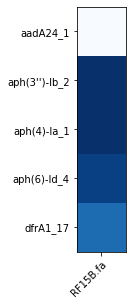

In [9]:
def merge_info(x):
    m=info[['id','stage']]
    x=m.merge(x,right_index=True,left_on='id')
    x=x.set_index(['stage','id'])
    return x

def plot_heatmap(m, fig=None, title=''):

    from matplotlib.gridspec import GridSpec
    l=l=1+int(len(m)/30)
    if fig == None:
        fig = plt.figure()
    gs = fig.add_gridspec(1, l)
    chunks = np.array_split(m,l)
    i=0
    for df in chunks:
        ax = fig.add_subplot(gs[0,i])
        im = ax.imshow(df, cmap='Blues')
        ax.set_xticks(np.arange(len(df.T)))
        ax.set_yticks(np.arange(len(df)))
        ax.set_xticklabels(df.columns)
        ax.set_yticklabels(df.index)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        i+=1
    fig.suptitle(title)
    #plt.tight_layout()
    fig.subplots_adjust(wspace=1.2, bottom=.2)
    return

fig = plt.figure(figsize=(10,5))
plot_heatmap(m.T, fig=fig)

blasting 2617 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db targets.fasta -evalue 0.1 -max_target_seqs 100 -num_threads 2


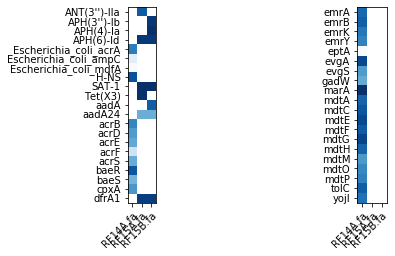

In [10]:
# run in sequence

def run(filenames, db='card'):
    """Run pipeline"""
    
    fetch_sequence_db(db)
    make_blast_database(filenames)
    bl = find_genes('targets.fasta', db)
    #find_gene_hits(bl, 'dfrA1_9', '../test_files/RF15B.fa', db)
    bl.to_csv('%s_results.csv' %db)
    m = pivot_blast_results(bl)
    #print (m)
    plot_heatmap(m.T)
    m.to_csv('%s_matrix.csv' %db)
    return

inpath = '../test_files/'
filenames = glob.glob(os.path.join(inpath,'*.fa*'))
#run(filenames, db='resfinder')
run(filenames, db='card')

In [11]:
def abricate(filename, db='card',id=None):
    
    cmd = '/local/abricate/bin/abricate %s -db %s --mincov 50 --minid 90 > temp.tab' %(filename,db)
    print (cmd)
    subprocess.check_output(cmd, shell=True, executable='/bin/bash')
    df = pd.read_csv('temp.tab',sep='\t')
    id = os.path.basename(filename)
    df['id'] = id
    return df

x = abricate('../test_files/RF15B.fa')

/local/abricate/bin/abricate ../test_files/RF15B.fa -db card --mincov 50 --minid 90 > temp.tab


In [12]:
make_blast_database(['../test_files/RF15B.fa'])
y = find_genes('targets.fasta', 'card', coverage=50, ident=90)

blasting 2617 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db targets.fasta -evalue 0.1 -max_target_seqs 100 -num_threads 2


0       CTX-M-144
1    ANT(3'')-IIa
2           SAT-1
3           dfrA1
4       APH(6)-Id
5     APH(3'')-Ib
6         Tet(X3)
7       AAC(3)-IV
8       APH(4)-Ia
Name: GENE, dtype: object
12      CTX-M-107
85         aadA24
76           aadA
73          SAT-1
92          dfrA1
7       APH(6)-Id
3     APH(3'')-Ib
4       APH(4)-Ia
Name: gene, dtype: object


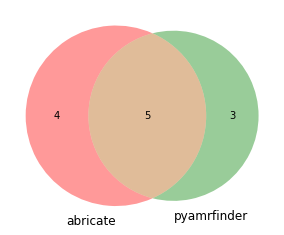

In [13]:
print (x.GENE)
print (y.gene)

from matplotlib_venn import venn2
venn2([set(x.GENE),set(y.gene)],['abricate','pyamrfinder'])

## benchmarking

* https://aac.asm.org/content/63/11/e00483-19
* https://www.ncbi.nlm.nih.gov/pubmed/27365186

## use raw reads

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4237778/

In [27]:
def find_reads(idx, file1, file2, bamfile, threads=4):
    
    cmd = 'bwa mem -M -t {t} {i} {f1} {f2} | samtools sort | samtools view -bS - > {o}'.format(i=idx,f1=file1,f2=file2,o=bamfile,t=threads)
    print (cmd)
    #subprocess.check_output(cmd, shell=True)    
    return

bamfile = 'out.bam'
db=os.path.join(dbdir, 'card.fa')
cmd = 'bwa index %s' %db
print (cmd)
subprocess.check_output(cmd, shell=True)

find_reads(db, '../test_reads/RF12A_S17_L001_R1_001.fastq.gz', '../test_reads/RF12A_S17_L001_R2_001.fastq.gz', out, 8)


bwa index /home/farrell/.config/pyamrfinder/db/card.fa
bwa mem -M -t 8 /home/farrell/.config/pyamrfinder/db/card.fa ../test_reads/RF12A_S17_L001_R1_001.fastq.gz ../test_reads/RF12A_S17_L001_R2_001.fastq.gz | samtools sort | samtools view -bS - > out.bam


In [30]:
threads=8
out = 'out.vcf'
cmd = 'bcftools mpileup --skip-indels --threads {t} --output-type v -f {db} --output {o} {b}'.format(db=db,o=out,b=bamfile,t=threads)
print(cmd)

bcftools mpileup --skip-indels --threads 8 --output-type v -f /home/farrell/.config/pyamrfinder/db/card.fa --output out.vcf out.bam


## dna_features_viewer

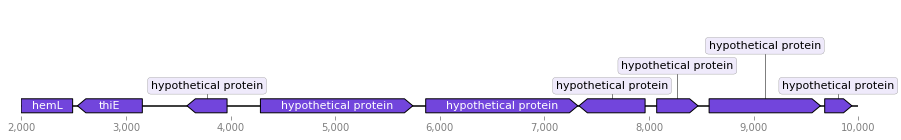

In [109]:
from dna_features_viewer import GraphicFeature, GraphicRecord
from dna_features_viewer import BiopythonTranslator

start = 2000
end = 10000
rec = recs[0]
#recs = list(SeqIO.parse('annot.gbk',format='gb'))
#rec = x[0]

graphic_record = BiopythonTranslator().translate_record(rec)
cropped_record = graphic_record.crop((start, end))
fig,ax=plt.subplots(1,1,figsize=(15,2))
ax, _ = cropped_record.plot(figure_width=15, strand_in_label_threshold=7, ax=ax)
